In [2]:
#Loading the original tables into dataframes
#df_accident=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1979-2021.csv', sep=',', header=0)
#df_vehicle=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-vehicle-1979-2021.csv', sep=',', header=0)
#df_casualty=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-casualty-1979-2021.csv', sep=',', header=0)

In [2]:
import pygeohash as gh
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%load_ext autoreload
%autoreload 2

sys.path.append(os.path.dirname(sys.path[0]))

from python.data_cleaning import prepare_data_for_groupby
from python.grouped_data import data_for_analysis
from python import mlmodel

2022-12-08 15:36:53.677778: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 15:36:54.045061: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-08 15:36:54.045085: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-08 15:37:00.224736: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
#Filtering the dataframes to get dta from 1999 only
#df_accident_1999=df_accident[df_accident['accident_year']>=1999]
#df_vehicle_1999=df_vehicle[df_vehicle['accident_year']>=1999]
#df_casualty_1999=df_casualty[df_casualty['accident_year']>=1999]

In [3]:
#Exporting the data from 1999 as csv files --> the new raw data files
#df_accident_1999.to_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1999-2021.csv')
#df_vehicle_1999.to_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-vehicle-1999-2021.csv')
#df_casualty_1999.to_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-casualty-1999-2021.csv')

In [3]:
df_accidents=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1999-2021.csv', index_col=0)
df_accidents.head()

/tmp/ipykernel_2417/1322138315.py:1: DtypeWarning: Columns (1,3,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accidents=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1999-2021.csv', index_col=0)


,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
4883216,1999010SU0945,1999,010SU0945,519490.0,203300.0,-0.271752,51.715661,1,3,1,...,0,1,4,1,0,0,2,1,1,E01023583
4883217,1999010SU0946,1999,010SU0946,521740.0,201070.0,-0.239977,51.695136,1,3,2,...,0,6,4,1,0,0,2,1,1,E01023584
4883218,1999010SU0947,1999,010SU0947,519610.0,203240.0,-0.270037,51.715096,1,3,2,...,0,4,1,2,0,0,2,1,1,E01023583
4883219,1999010SU0948,1999,010SU0948,520090.0,202830.0,-0.263233,51.711309,1,2,2,...,0,6,1,1,0,0,2,1,1,E01023583
4883220,1999010SU0949,1999,010SU0949,522640.0,200320.0,-0.227225,51.688200,1,3,4,...,0,1,1,2,0,0,2,1,1,E01023584


In [4]:
test=prepare_data_for_groupby(df_accidents,6)

In [5]:
test_data=data_for_analysis(test,granularity='W')
test_data.head(52)

,Accidents
date,
1999-01-04,1586
1999-01-11,4623
1999-01-18,5000
1999-01-25,4589
1999-02-01,4137
1999-02-08,3986
1999-02-15,4320
1999-02-22,3902
1999-03-01,4321


In [6]:
test_data.shape

(1201, 1)

In [7]:
hashes=pd.DataFrame(test[['geohash','accident_year']].groupby('geohash').count())
hashes.columns=['Accidents']
hashes.sort_values('Accidents',inplace=True,ascending=False)
hashes.shape


(184578, 1)

In [8]:
hashes.describe()

,Accidents
count,184578.000000
mean,20.676852
std,57.175713
min,1.000000
25%,2.000000
50%,5.000000
75%,16.000000
max,2045.000000


In [9]:
hashes[hashes['Accidents']>=500]

,Accidents
geohash,
gcpvj0,2045
gcpvhc,1959
gcpvj4,1871
gcpvj1,1816
gcpuv2,1744
...,...
u10her,502
gcwdpd,502
gcpuv5,501


In [10]:
#Isolating the square where there are more accidents
max_square=hashes[hashes['Accidents']==hashes.Accidents.max()].index[0]
max_square

'gcpvj0'

In [11]:
#Filtering the data for the max_square
test_max_square=test[test['geohash']==max_square]
test_max_square.shape

(2045, 13)

In [12]:
test_data_max_square=data_for_analysis(test_max_square,'W')
test_data_max_square.head(50)

,Accidents
date,
1999-01-04,1
1999-01-11,1
1999-01-18,1
1999-01-25,1
1999-02-01,1
1999-02-08,4
1999-02-15,3
1999-02-22,5
1999-03-01,2


In [14]:
time_series=data_for_analysis(test,'W')

In [15]:
FOLD_LENGTH=208 #each fold spans over 4 years
FOLD_STRIDE=52 #we have a  fold every 1 year
INPUT_LENGTH=10 #every X_i sequence is 10 weeks long
TRAIN_TEST_RATIO=.75 #in each fold, we use 3 years for training and 1 year for test
OUTPUT_LENGTH=10 #we want to predict the number of accidents in the next 10 weeks (y_i length)
SEQUENCE_STRIDE = 1

In [16]:
folds=mlmodel.get_folds(time_series,FOLD_LENGTH,FOLD_STRIDE)
np.array(folds).shape

(20, 208, 1)

In [17]:
fold1=folds[0]

In [18]:
(fold1_train, fold1_test) = mlmodel.train_test_split(fold1, TRAIN_TEST_RATIO, INPUT_LENGTH)
fold1_train.shape

(156, 1)

In [19]:
X_train1, y_train1 = mlmodel.get_X_y_strides(fold1_train,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)
X_test1, y_test1 = mlmodel.get_X_y_strides(fold1_test,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)

In [20]:
X_train1.shape

(137, 10, 1)

In [21]:
model = mlmodel.init_model(X_train1)

2022-12-08 15:43:14.246761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-08 15:43:14.247619: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-08 15:43:14.248316: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-08 15:43:14.248794: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-08 15:43:14.248876: W tensorf

In [22]:
model, history = mlmodel.fit_model(model,X_train1,y_train1)

Epoch 1/500
3/3 [==============================] - 6s 376ms/step - loss: 20412640.0000 - mae: 4492.3350 - val_loss: 18735028.0000 - val_mae: 4315.5674
Epoch 2/500
3/3 [==============================] - 0s 49ms/step - loss: 19941202.0000 - mae: 4439.5610 - val_loss: 17678634.0000 - val_mae: 4191.4033
Epoch 3/500
3/3 [==============================] - 0s 49ms/step - loss: 18364002.0000 - mae: 4257.5996 - val_loss: 15070242.0000 - val_mae: 3867.7034
Epoch 4/500
3/3 [==============================] - 0s 58ms/step - loss: 14851083.0000 - mae: 3817.1936 - val_loss: 10310161.0000 - val_mae: 3192.9983
Epoch 5/500
3/3 [==============================] - 0s 57ms/step - loss: 9562795.0000 - mae: 3007.0952 - val_loss: 4068348.5000 - val_mae: 1983.9952
Epoch 6/500
3/3 [==============================] - 0s 56ms/step - loss: 3508914.5000 - mae: 1628.7994 - val_loss: 195677.7188 - val_mae: 314.9722
Epoch 7/500
3/3 [==============================] - 0s 54ms/step - loss: 2687709.7500 - mae: 1289.6710 - v

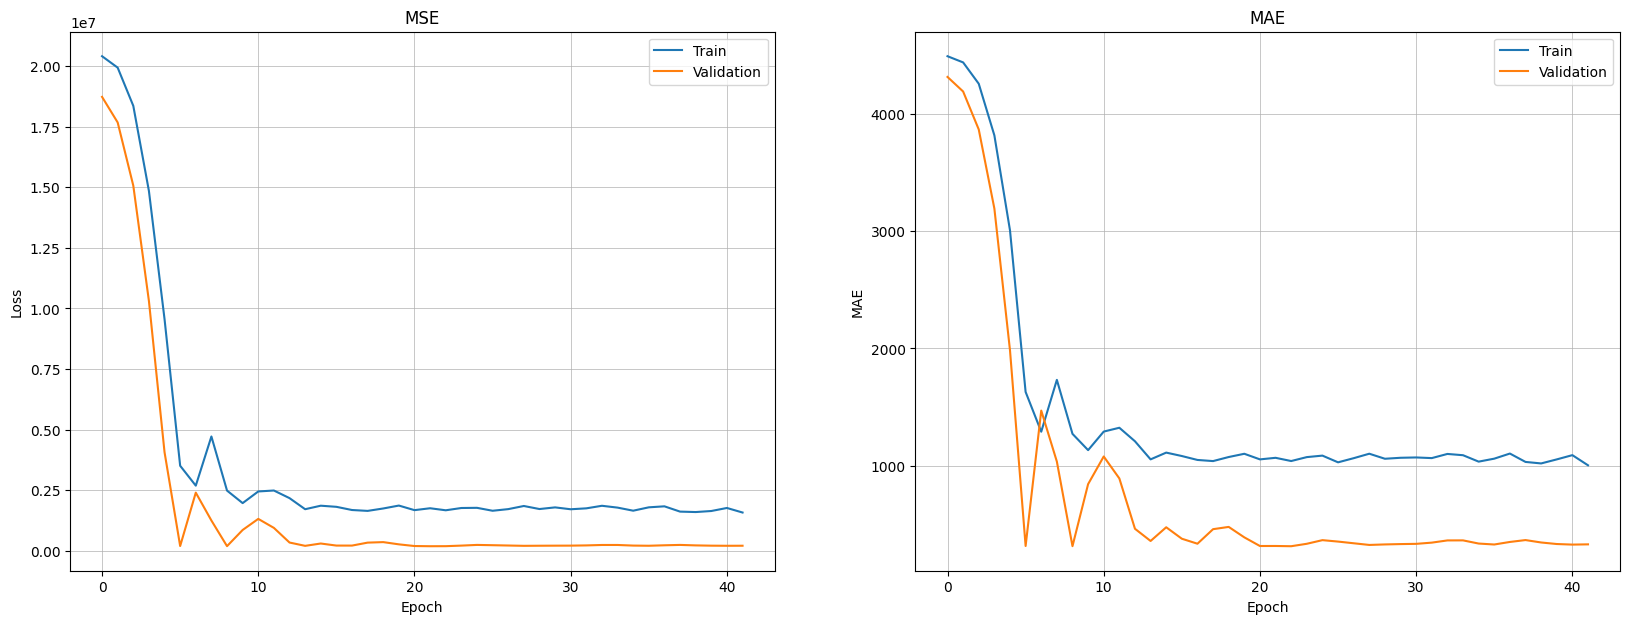

In [23]:
mlmodel.plot_history(history);

In [24]:
res=model.evaluate(X_test1,y_test1)

2/2 [==============================] - 0s 12ms/step - loss: 188904.9531 - mae: 366.8817


In [25]:
baseline_model = mlmodel.init_baseline(OUTPUT_LENGTH)
baseline_score = baseline_model.evaluate(X_test1, y_test1)

2/2 [==============================] - 0s 8ms/step - loss: 271393.3125 - mae: 425.6418


In [26]:
print(f"The LSTM MAE on the test set is equal to {round(res[1],2)} accidents")
print(f"Improvement of the LSTM model over the baseline (on this fold for the test set) = : {round((1 - (res[1]/baseline_score[1]))*100,2)} %")

The LSTM MAE on the test set is equal to 366.88 accidents
Improvement of the LSTM model over the baseline (on this fold for the test set) = : 13.81 %


In [27]:
y_pred1=model.predict(X_test1)
y_bas_pred1=baseline_model.predict(X_test1)

2/2 [==============================] - 0s 5ms/step


In [29]:
mae_baselines, mae_lstms = mlmodel.cross_validate_baseline_and_lstm(test_data_max_square,FOLD_LENGTH, FOLD_STRIDE,
                                     TRAIN_TEST_RATIO, INPUT_LENGTH,
                                     OUTPUT_LENGTH, SEQUENCE_STRIDE)

20
--------------------------------------------------
MAE baseline fold n°0 = 1.5
MAE LSTM fold n°0 = 1.12
Improvement over baseline: 25.54 % 

--------------------------------------------------
MAE baseline fold n°1 = 1.65
MAE LSTM fold n°1 = 1.11
Improvement over baseline: 32.96 % 

--------------------------------------------------
MAE baseline fold n°2 = 1.67
MAE LSTM fold n°2 = 1.19
Improvement over baseline: 29.0 % 

--------------------------------------------------
MAE baseline fold n°3 = 1.27
MAE LSTM fold n°3 = 0.99
Improvement over baseline: 22.12 % 

--------------------------------------------------
MAE baseline fold n°4 = 1.27
MAE LSTM fold n°4 = 0.88
Improvement over baseline: 30.67 % 

--------------------------------------------------
MAE baseline fold n°5 = 1.11
MAE LSTM fold n°5 = 0.8
Improvement over baseline: 27.89 % 

--------------------------------------------------
MAE baseline fold n°6 = 1.6
MAE LSTM fold n°6 = 1.1
Improvement over baseline: 31.64 % 

--------

In [30]:
print(f"➡ Average percentage improvement over baseline = {round(np.mean(1 - np.array(mae_lstms)/np.array(mae_baselines)),2)*100}%")

➡ Average percentage improvement over baseline = 23.0%


In [31]:
np.mean(np.array(mae_lstms))

1.005556684732437

In [32]:
np.mean(np.array(mae_baselines))

1.3159302294254303

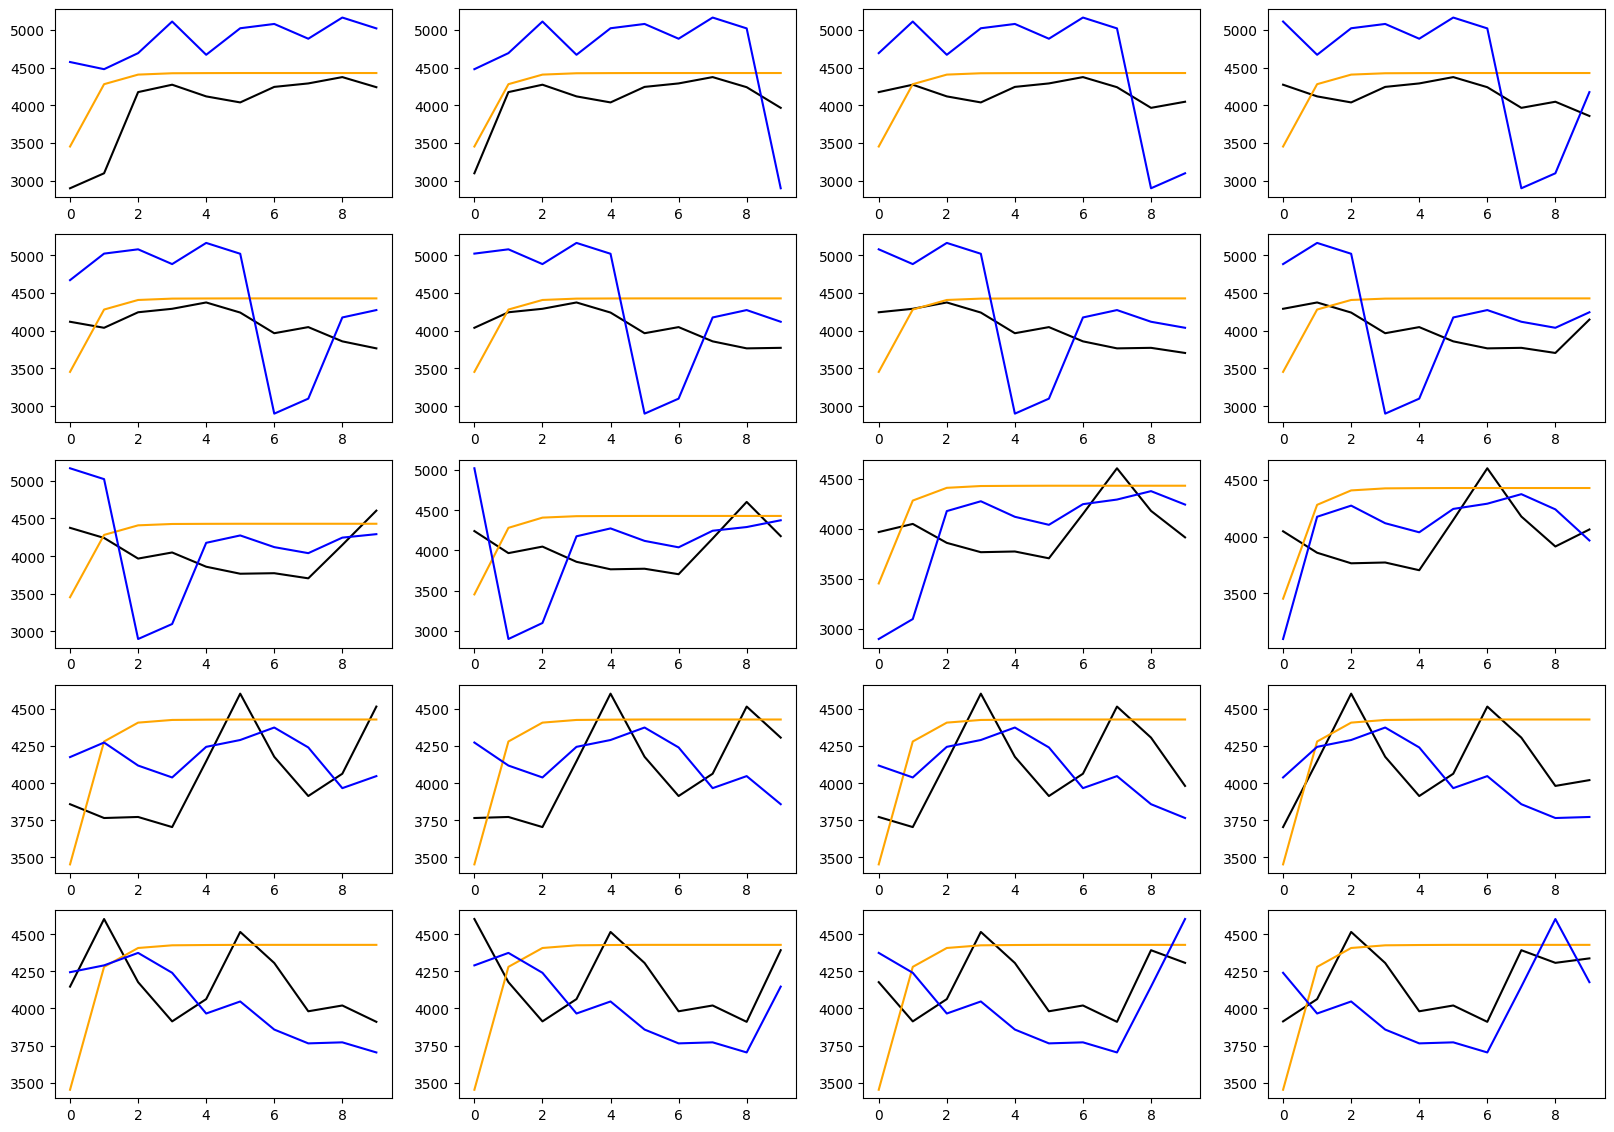

In [33]:
import seaborn as sns
plt.figure(figsize=(20, 20))
for id in range(0,20):
    plt.subplot(7,4,id+1)
    df_test=pd.DataFrame(y_test1[id])
    df_pred=pd.DataFrame(y_pred1[id].astype(int))
    df_bas_pred=pd.DataFrame(y_bas_pred1[id])
    plt.plot(df_test[0],c='black',label='test set')
    plt.plot(df_pred[0],c='orange',label='lstm prediction')
    plt.plot(df_bas_pred[0],c='blue',label='baseline prediction')
plt.show()